# Generating plots for Bridge2021

In [18]:
from putils import get_observation, plot_geometry, plot_matrix
from dautils import sample_winddirection, sample_windspeed, validate_geom, adjusted_state_EnKF_farsite, geom_to_state, align_states
from futils import forward_pass_farsite, generate_landscape

import datetime
import uuid

import numpy as np
from matplotlib import pyplot as plt

import contextily as ctx

import pickle
from shapely.geometry import Polygon
from tqdm import tqdm

## Load data

In [2]:
description = 'Bridge2021'

with open(f'/home/tcaglar/farsite-devAPI/data/Bridge2021_results_01102024_vsz100_wsz100.pkl', 'rb') as f:
    data = pickle.load(f)

adjusted_geom_lst = data['adjusted_geom']
zkphat_ensemble_lst = data['zkphat_ensemble_lst']
xkphat_ensemble_lst = data['xkphat_ensemble_lst']
ykhat_ensemble_lst = data['ykhat_ensemble_lst']

tfin = 6

## Load the observations

In [3]:
# # # Bridge fire wind values
wslst = [15]*(tfin)
wdlst = [270]*(tfin)


observations = []
timestamps = []
sampled_wslst = []
sampled_wdlst = []

for tix in tqdm(range(tfin)):
    obs, ts = get_observation(description, tix)
    observations.append(obs)
    timestamps.append(ts)

100%|██████████| 6/6 [00:00<00:00,  6.61it/s]


## Generate estimated ignition

In [4]:
# # Bridge2021 ignition
ignition_timepoint = timestamps[0].replace(hour=12, minute=53)
x,y = x,y = observations[0].centroid.x, observations[0].centroid.y
width = 100
xshift = -50
yshift = 50


x += xshift
y+= yshift
ignition = Polygon([(x-width, y), (x, y), (x,y-width), (x-width, y-width)])

lcppath = generate_landscape(ignition, description=description)

## Plot ignition + perimeters

0 days 00:00:00, 0 days 00:29:37
0 days 00:29:37, 0 days 00:27:47
0 days 00:57:24, 0 days 00:23:04
0 days 01:20:28, 0 days 00:33:07
0 days 01:53:35, 0 days 00:25:04
0 days 02:18:39


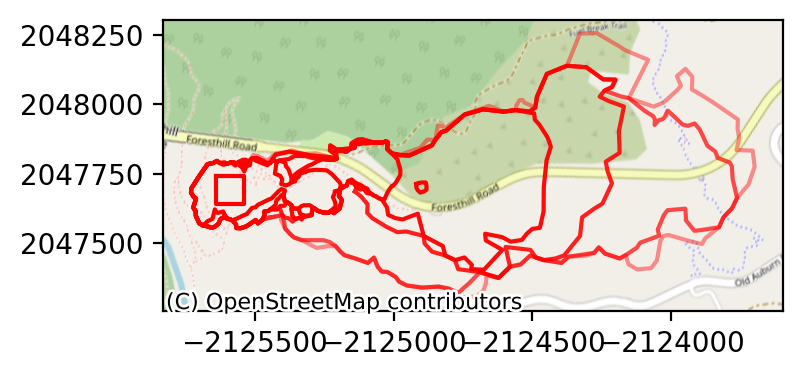

In [5]:
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)

plot_geometry(ignition, ax=ax, color='red')

for i in range(tfin):
    geom, timestamp = get_observation(description, i)
    plot_geometry(geom, ax=ax, label=timestamp, color=(1,0,0,1-(i/tfin)**3))

    if i < (tfin-1):
        print(f'{timestamp - timestamps[0]}, {timestamps[i+1]-timestamps[i]}')
    else:
        print(f'{timestamp - timestamps[0]}')


ctx.add_basemap(ax=ax, source=ctx.providers.OpenStreetMap.Mapnik, crs='EPSG:5070')

xlim = ax.get_xlim()
ylim = ax.get_ylim()

In [6]:
dt = timestamps[0] - ignition_timepoint
n_vertex = 20

dist_res = int(ignition.exterior.length/n_vertex)
perim_res = dist_res

forward_geom = forward_pass_farsite(ignition, {'windspeed': wslst[0],
                                                     'winddirection': wdlst[0],
                                                     'dt': dt},
                                    lcppath=lcppath, description=description,
                                    dist_res=dist_res, perim_res=perim_res)

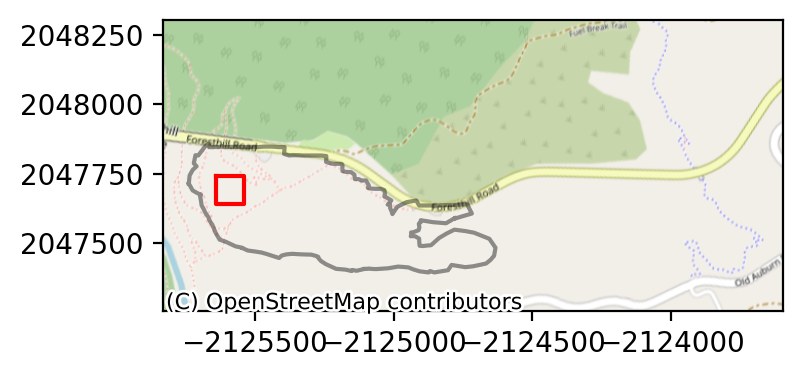

In [7]:
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)

plot_geometry(ignition, ax=ax, color='red')
plot_geometry(forward_geom, ax=ax, label=timestamps[0], color=(0,0,0,1-(i/tfin)**3))

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ctx.add_basemap(ax=ax, source=ctx.providers.OpenStreetMap.Mapnik, crs='EPSG:5070')

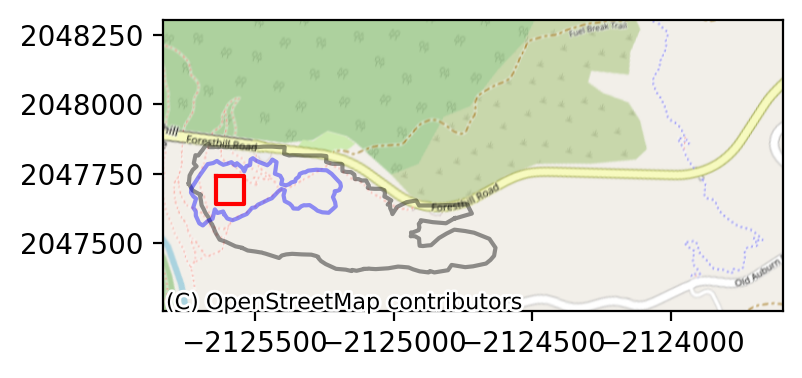

In [8]:
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)

plot_geometry(ignition, ax=ax, color='red')
plot_geometry(forward_geom, ax=ax, label=timestamps[0], color=(0,0,0,1-(i/tfin)**3))
plot_geometry(observations[0], ax=ax, label=timestamps[0], color=(0,0,1,1-(i/tfin)**3))

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ctx.add_basemap(ax=ax, source=ctx.providers.OpenStreetMap.Mapnik, crs='EPSG:5070')

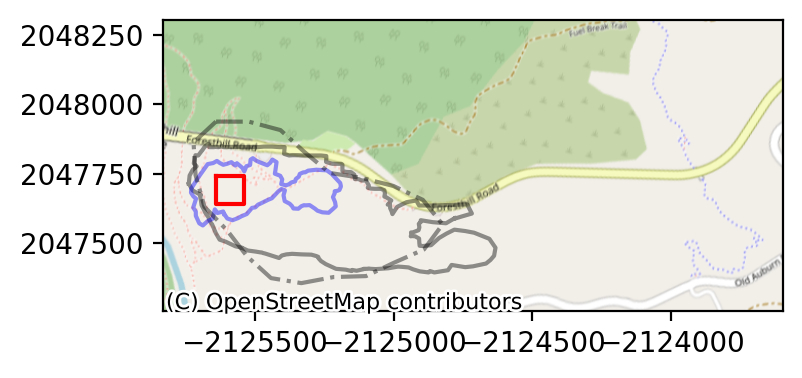

In [9]:
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)

plot_geometry(ignition, ax=ax, color='red')
plot_geometry(forward_geom, ax=ax, label=timestamps[0], color=(0,0,0,1-(i/tfin)**3))
plot_geometry(observations[0], ax=ax, label=timestamps[0], color=(0,0,1,1-(i/tfin)**3))
plot_geometry(adjusted_geom_lst[0], ax=ax, label=timestamps[0], color=(0,0,0,1-(i/tfin)**3), ls='-.')

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ctx.add_basemap(ax=ax, source=ctx.providers.OpenStreetMap.Mapnik, crs='EPSG:5070')

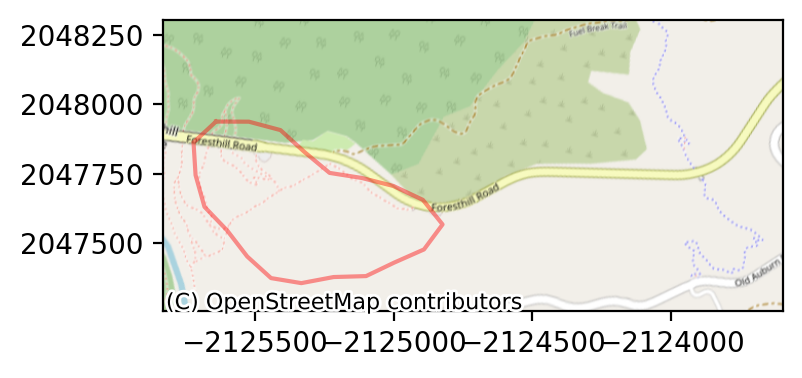

In [10]:
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)

plot_geometry(adjusted_geom_lst[0], ax=ax, label=timestamps[0], color=(1,0,0,1-(i/tfin)**3))

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ctx.add_basemap(ax=ax, source=ctx.providers.OpenStreetMap.Mapnik, crs='EPSG:5070')

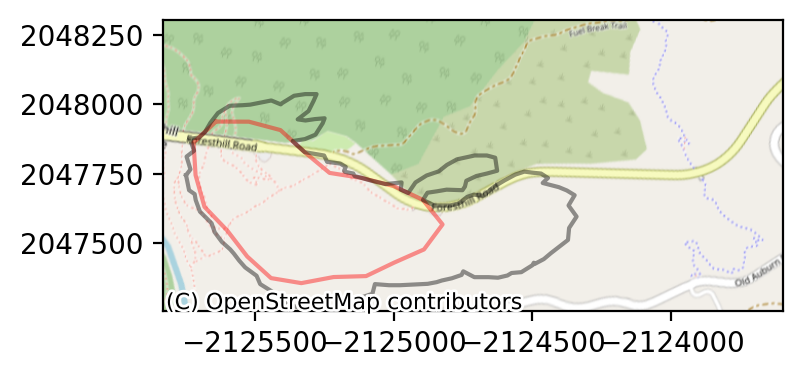

In [11]:
dt = timestamps[1] - timestamps[0]

dist_res = int(adjusted_geom_lst[0].exterior.length/n_vertex)
perim_res = dist_res

forward_geom = forward_pass_farsite(adjusted_geom_lst[0], 
                                     params = {'windspeed': wslst[0],
                                               'winddirection': wdlst[0],
                                               'dt': dt},
                                    lcppath=lcppath, description=description,
                                    dist_res=dist_res, perim_res=perim_res)

fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)

plot_geometry(adjusted_geom_lst[0], ax=ax, label=timestamps[0], color=(1,0,0,1-(i/tfin)**3))
plot_geometry(forward_geom, ax=ax, label=timestamps[0], color=(0,0,0,1-(i/tfin)**3))

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ctx.add_basemap(ax=ax, source=ctx.providers.OpenStreetMap.Mapnik, crs='EPSG:5070')

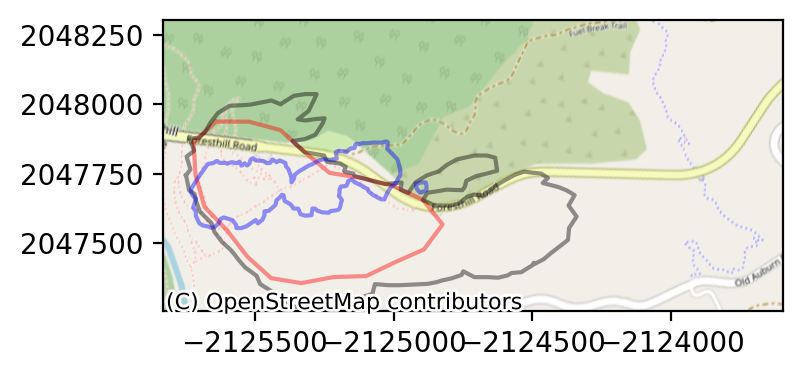

In [12]:
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)

plot_geometry(adjusted_geom_lst[0], ax=ax, label=timestamps[0], color=(1,0,0,1-(i/tfin)**3))
plot_geometry(forward_geom, ax=ax, label=timestamps[0], color=(0,0,0,1-(i/tfin)**3))
plot_geometry(observations[1], ax=ax, label=timestamps[0], color=(0,0,1,1-(i/tfin)**3))

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ctx.add_basemap(ax=ax, source=ctx.providers.OpenStreetMap.Mapnik, crs='EPSG:5070')

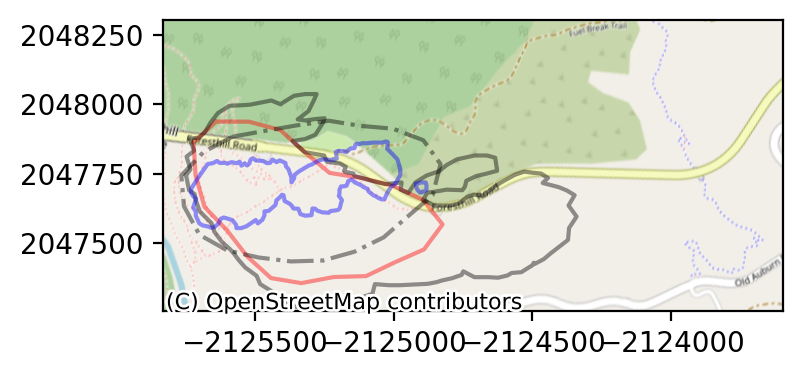

In [13]:
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)

plot_geometry(adjusted_geom_lst[0], ax=ax, color=(1,0,0,1-(i/tfin)**3))
plot_geometry(forward_geom, ax=ax, color=(0,0,0,1-(i/tfin)**3))
plot_geometry(observations[1], ax=ax, color=(0,0,1,1-(i/tfin)**3))
plot_geometry(adjusted_geom_lst[1], ax=ax, color=(0,0,0,1-(i/tfin)**3), ls='-.')

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ctx.add_basemap(ax=ax, source=ctx.providers.OpenStreetMap.Mapnik, crs='EPSG:5070')

## Calculate error of the farsite solutions after input adjustment

In [14]:
adjusted_outputs = []

all_timestamps = [ignition_timepoint] + timestamps
all_ignitions = [ignition] + adjusted_geom_lst

for i in tqdm(range(len(all_timestamps)-1)):
    ws = wslst[i]
    wd = wdlst[i]
    dt = all_timestamps[i+1] - all_timestamps[i]

    initial = all_ignitions[i]
    dist_res = max(200, int(initial.exterior.length/n_vertex))
    perim_res = dist_res
    
    forward_geom = forward_pass_farsite(validate_geom(initial), 
                                     params = {'windspeed': ws,
                                               'winddirection': wd,
                                               'dt': dt},
                                       lcppath=lcppath, description=description,
                                       dist_res=dist_res, perim_res=perim_res)

    adjusted_outputs.append(validate_geom(forward_geom))

100%|██████████| 6/6 [00:00<00:00,  6.56it/s]


In [15]:
def calculate_rms_state(state1, state2):
    return ((state1 - state2)**2).mean()
def calculate_area_diff_state(state1, state2):
    geom1 = Polygon(zip(state1[::2], state1[1::2]))
    geom2 = Polygon(zip(state2[::2], state2[1::2]))
    
    return (geom1.union(geom2) - geom1.intersection(geom2)).area
def align_states(state_lst, vertex_count=None):
    if vertex_count is None:
        vertex_count = max(len(st) for st in state_lst)//2
    x0 = state_lst[0][::2]
    y0 = state_lst[0][1::2]
    x1 = state_lst[1][::2]
    y1 = state_lst[1][1::2]

    geom0 = Polygon(zip(x0,y0))
    geom1 = Polygon(zip(x1,y1))

    geom0, geom1 = align_geoms([geom0, geom1], vertex_count)
    x,y = geom0.exterior.coords.xy
    x0 = x.tolist()[:-1]
    y0 = y.tolist()[:-1]
    state0 = xy_to_state(x0, y0)
    
    x,y = geom1.exterior.coords.xy
    x1 = x.tolist()[:-1]
    y1 = y.tolist()[:-1]
    state1 = xy_to_state(x1, y1)

    return [state0, state1]
    
def xy_to_state(x, y):
    ret = []
    for i in range(len(x)):
        ret.append(x[i])
        ret.append(y[i])

    return np.array(ret).reshape((2*len(x),1))

def state_to_xy(state):
    return state[::2], state[1::2]

def sample_xy(x,y, rng, scale=100):
    xs = rng.normal(x, scale=scale)
    ys = rng.normal(y, scale=scale)

    return xs,ys

## Model output without data assimilation

### Calculate

In [16]:
no_ds_outputs = [ignition]
for tix in tqdm(range(tfin-1)):
    ws = wslst[tix]
    wd = wdlst[tix]
    dt = timestamps[tix+1]-timestamps[tix]
    
    dist_res = max(200, int(no_ds_outputs[-1].exterior.length/n_vertex))
    perim_res = dist_res
    
    model_geom = forward_pass_farsite(no_ds_outputs[-1],
                                     params = {'windspeed': ws,
                                               'winddirection': wd,
                                               'dt': dt},
                                     lcppath=lcppath, description=description,
                                     dist_res=dist_res, perim_res=perim_res)
    no_ds_outputs.append(model_geom)
    

100%|██████████| 5/5 [00:00<00:00,  8.26it/s]


In [39]:
full_ds_outputs = [ignition]
for tix in tqdm(range(tfin-1)):
    ws = wslst[tix]
    wd = wdlst[tix]
    dt = timestamps[tix+1]-timestamps[tix]
    
    if tix==0:
        initial = ignition
    else:
        initial = validate_geom(observations[tix])
    
    dist_res = max(200, int(initial.exterior.length/n_vertex))
    perim_res = dist_res
    
    model_geom = forward_pass_farsite(initial,
                                     params = {'windspeed': ws,
                                               'winddirection': wd,
                                               'dt': dt},
                                     lcppath=lcppath, description=description,
                                     dist_res=dist_res, perim_res=perim_res)
    full_ds_outputs.append(model_geom)
    

100%|██████████| 5/5 [00:00<00:00,  6.45it/s]


In [19]:
adjusted_errors = []
no_adjusted_errors = []
for i in tqdm(range(tfin)):
    st_adj = geom_to_state(validate_geom(adjusted_geom_lst[i]))
    st_obs = geom_to_state(validate_geom(observations[i]))
    st_noadj = geom_to_state(validate_geom(no_ds_outputs[i]))
    st1, st2 = align_states([st_obs, st_adj], vertex_count=1000)
    adjusted_errors.append(calculate_rms_state(st1, st2))

    st1, st2 = align_states([st_obs, st_noadj], vertex_count=1000)
    no_adjusted_errors.append(calculate_rms_state(st1, st2))

100%|██████████| 6/6 [00:00<00:00,  9.38it/s]


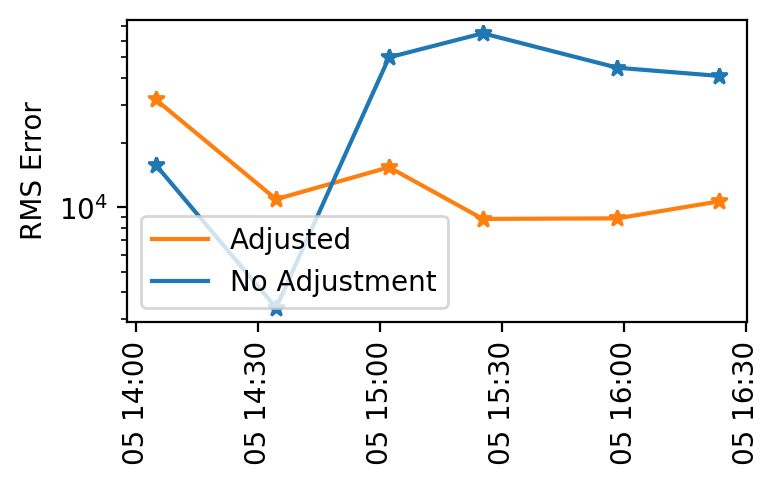

In [20]:
fig, ax = plt.subplots(1,1, figsize=(4,2), dpi=200)
ax.semilogy([ts.to_datetime64() for ts in all_timestamps[1:]], adjusted_errors, label='Adjusted', color='tab:orange')
ax.semilogy([ts.to_datetime64() for ts in all_timestamps[1:]], adjusted_errors, '*', color='tab:orange')
ax.semilogy([ts.to_datetime64() for ts in all_timestamps[1:]], no_adjusted_errors, label='No Adjustment', color='tab:blue')
ax.semilogy([ts.to_datetime64() for ts in all_timestamps[1:]], no_adjusted_errors, '*', color='tab:blue')
ax.tick_params(axis='x', labelrotation=90)

ax.set_ylabel('RMS Error')
ax.legend()

### Redefine variables based on outputs

In [43]:
############# TODO

z = [no_ds_outputs[0]]
x = [no_ds_outputs[0]]
y = [no_ds_outputs[0]]
t = [all_timestamps[0]]
xf = [full_ds_outputs[0]]

for tix in range(1,len(all_timestamps)-1):
    z.append(no_ds_outputs[tix])
    if tix == 1:
        x.append(z[-1])
        xf.append(z[-1])
    else:
        x.append(adjusted_geom_lst[tix-2])
        xf.append(full_ds_outputs[tix-2])
        
    y.append(observations[tix-1])
    t.append(all_timestamps[tix])
    

In [44]:
no_adjusted_errors = []
adjusted_errors = []
full_da_errors = []

for zz, xx, yy, xxff in zip(z,x,y, xf):
    st_adj = geom_to_state(validate_geom(xx))
    st_obs = geom_to_state(validate_geom(yy))
    st_noadj = geom_to_state(validate_geom(zz))
    st_full = geom_to_state(validate_geom(xxff))
    
    st1, st2 = align_states([st_obs, st_adj], vertex_count=1000)
    adjusted_errors.append(calculate_rms_state(st1, st2))

    st1, st2 = align_states([st_obs, st_noadj], vertex_count=1000)
    no_adjusted_errors.append(calculate_rms_state(st1, st2))
    
    st1, st2 = align_states([st_obs, st_full], vertex_count=1000)
    full_da_errors.append(calculate_rms_state(st1, st2))

Text(0.5, 1.0, 'Bridge2021')

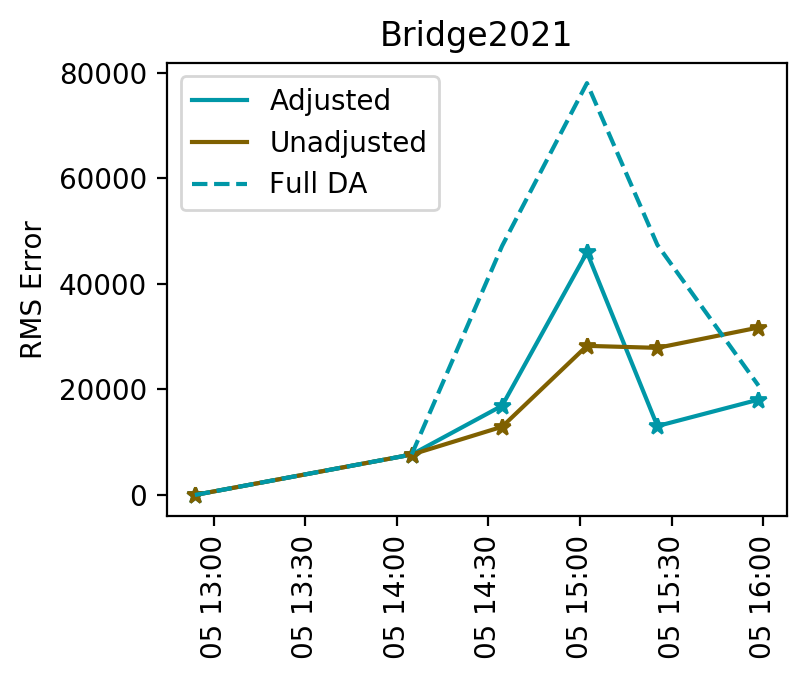

In [45]:
fig, ax = plt.subplots(1,1, figsize=(4,3), dpi=200)
ax.plot([ts.to_datetime64() for ts in all_timestamps[:-1]], adjusted_errors, label='Adjusted', color='#0097a7')
ax.plot([ts.to_datetime64() for ts in all_timestamps[:-1]], adjusted_errors, '*', color='#0097a7')
ax.plot([ts.to_datetime64() for ts in all_timestamps[:-1]], no_adjusted_errors, label='Unadjusted', color='#7f6000')
ax.plot([ts.to_datetime64() for ts in all_timestamps[:-1]], no_adjusted_errors, '*', color='#7f6000')
ax.plot([ts.to_datetime64() for ts in all_timestamps[:-1]], full_da_errors, ls='--', label='Full DA', color='#0097a7')

ax.tick_params(axis='x', labelrotation=90)

ax.set_ylabel('RMS Error')
ax.legend(loc='upper left')

ax.set_title(description)

## Plot model outputs

Text(0.5, 1, 'Unadjusted outputs')

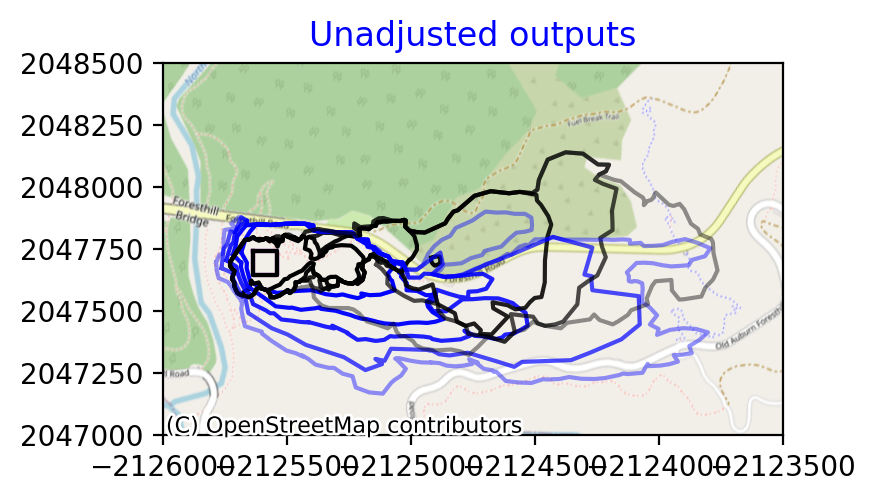

In [38]:
fig, ax = plt.subplots(1,1, figsize=(4,3), dpi=200)

plot_geometry(ignition, ax=ax, color='red')
for i in range(tfin):
    plot_geometry(z[i], ax=ax, color=(0,0,1,1-(i/tfin)**3))
    plot_geometry(y[i], ax=ax, color=(0,0,0,1-(i/tfin)**3))

# Maria boundaries
# ax.set_xlim(-13259480.899793554, -13248356.055776488)
# ax.set_ylim(4066612.9682816155, 4075471.350794237)

# Bridge boundaries
ax.set_xlim(-2.1260e6, -2.1235e6)
ax.set_ylim(2.0470e6, 2.0485e6)

# River boundaries
# ax.set_xlim(-2.1260e6, -2.1235e6)
# ax.set_ylim(2.0470e6, 2.0485e6)

ctx.add_basemap(ax=ax, source=ctx.providers.OpenStreetMap.Mapnik, crs='EPSG:5070')
ax.set_title('Unadjusted outputs', color='blue')

Text(0.5, 1, 'Adjusted outputs')

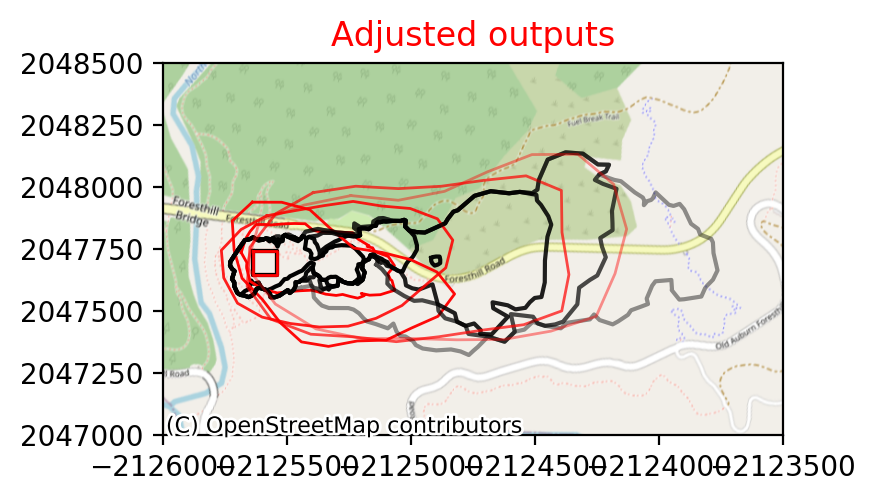

In [37]:
wdlstfig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)

plot_geometry(ignition, ax=ax, color='red')
for i in range(tfin):
    plot_geometry(y[i], ax=ax, color=(0,0,0,1-(i/tfin)**3))
    plot_geometry(x[i], ax=ax, color=(1,0,0,1-(i/tfin)**3), ls='-', lw=1)

#     zkphat_ensemble = zkphat_ensemble_lst[i]
#     plot_matrix(zkphat_ensemble, ax=ax, color=(0,0,1,1-(i/tfin)**3), ls='--', lw=1)
# Maria boundaries
# ax.set_xlim(-13259480.899793554, -13248356.055776488)
# ax.set_ylim(4066612.9682816155, 4075471.350794237)

# Bridge boundaries
ax.set_xlim(-2.1260e6, -2.1235e6)
ax.set_ylim(2.0470e6, 2.0485e6)

# River boundaries
# ax.set_xlim(-2.1260e6, -2.1235e6)
# ax.set_ylim(2.0470e6, 2.0485e6)

ctx.add_basemap(ax=ax, source=ctx.providers.OpenStreetMap.Mapnik, crs='EPSG:5070')
ax.set_title('Adjusted outputs', color='red')